In [ ]:

import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
%matplotlib inline
from wordcloud import WordCloud,STOPWORDS
import re
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
import string
import nltk as nlp
nltk.download('punkt')
nltk.download('wordnet')
from scipy import signal
from scipy.stats import shapiro
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
import warnings

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
!ls "/content/gdrive/"

MyDrive  Shareddrives


In [ ]:
!ls "/content/gdrive/My Drive/Colab Notebooks/USAirlineTweets"

database.sqlite  Tweets.csv


In [ ]:
datadir="/content/gdrive/My Drive/Colab Notebooks/USAirlineTweets/"

In [ ]:
df['negativereason_gold'].unique()

array([nan, 'Late Flight\nFlight Attendant Complaints',
       'Late Flight\nLost Luggage', 'Late Flight',
       'Customer Service Issue', "Can't Tell",
       'Cancelled Flight\nCustomer Service Issue', 'Cancelled Flight',
       'Bad Flight', 'Lost Luggage\nDamaged Luggage',
       'Late Flight\nCancelled Flight', 'Flight Attendant Complaints',
       'Customer Service Issue\nLost Luggage',
       "Customer Service Issue\nCan't Tell"], dtype=object)

In [ ]:
df.shape

(14640, 15)

In [ ]:
df.isnull().sum()

tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64

In [ ]:
df.airline.value_counts()


United            3822
US Airways        2913
American          2759
Southwest         2420
Delta             2222
Virgin America     504
Name: airline, dtype: int64

In [ ]:
air_senti=pd.crosstab(df.airline, df.airline_sentiment)
air_senti


airline_sentiment,negative,neutral,positive
airline,,,
American,1960,463,336
Delta,955,723,544
Southwest,1186,664,570
US Airways,2263,381,269
United,2633,697,492
Virgin America,181,171,152


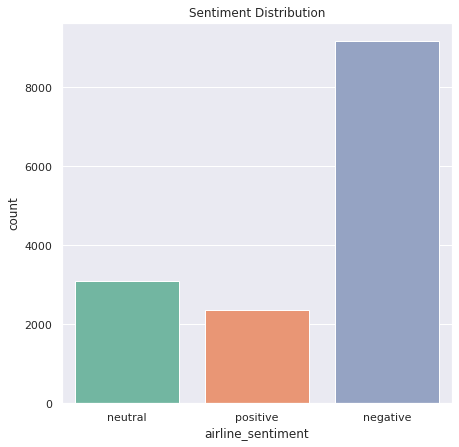

In [ ]:
sns.set()
plt.figure(figsize=(7,7))
sns.countplot(x=df["airline_sentiment"],palette="Set2")
plt.title("Sentiment Distribution")
plt.show()

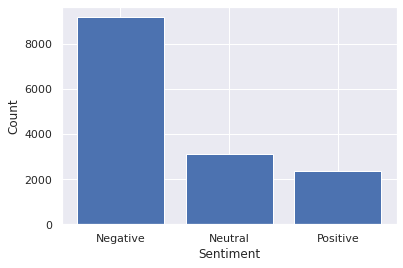

In [ ]:
plt.bar([1,2,3],df['airline_sentiment'].value_counts())
plt.xlabel('Sentiment')
plt.xticks([1,2,3],['Negative','Neutral','Positive'])
plt.ylabel('Count')
plt.show()

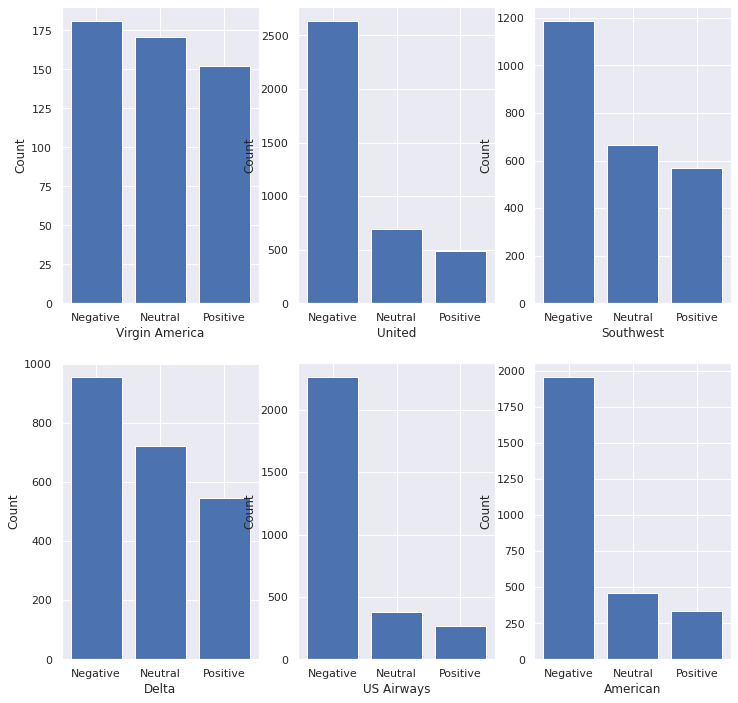

In [ ]:
# Now we will see what are the comments that a specific airlines gets.


airlines =df['airline'].unique()
counts=df['airline'].value_counts()

index=[1,2,3]
plt.figure(figsize=(12,12))
def airline_sentiment_plotter():
    for i in range(len(airlines)):
        plt.subplot(2,3,i+1)
        df1 =df[df['airline']==airlines[i]]
        counts =df1['airline_sentiment'].value_counts()
        plt.bar(index,counts)
        plt.xlabel(airlines[i])    
        plt.ylabel('Count')
        plt.xticks(index,['Negative','Neutral','Positive'])
airline_sentiment_plotter()

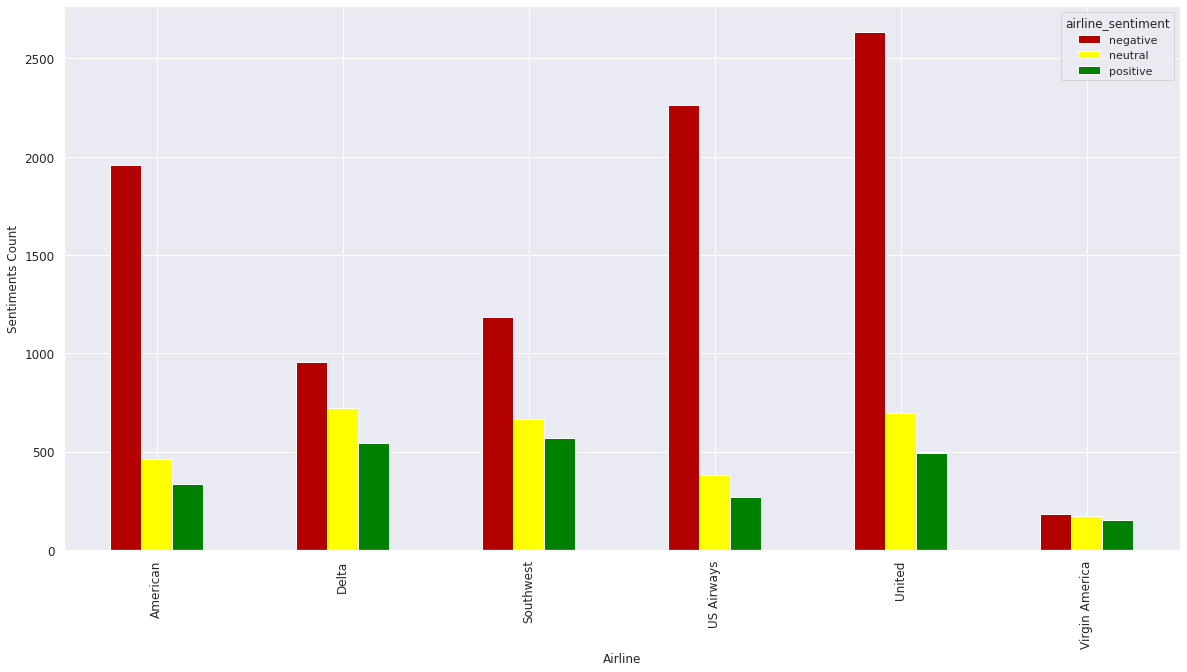

In [ ]:
sentiment_plot = df.groupby(['airline', 'airline_sentiment']).airline_sentiment.count().unstack().plot(kind = 'bar', figsize = (20, 10), fontsize = 12.0, xlabel = ('Airline'), ylabel = 'Sentiments Count', color=['#b30000', 'yellow', 'green'])


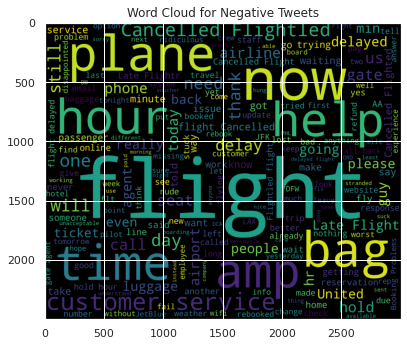

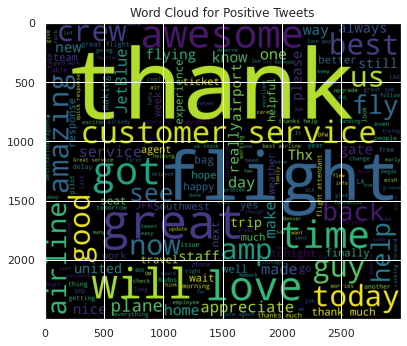

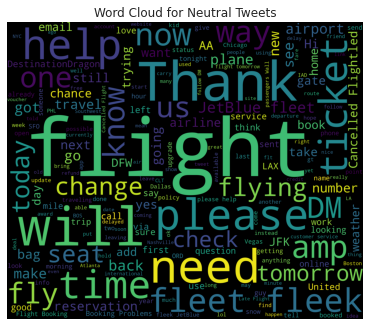

In [ ]:

def wordcloud_show(df):
    words = ' '.join(df['text'])
    cleaned_word = " ".join([word for word in words.split()
                                if 'http' not in word
                                    and not word.startswith('@')
                                    and word != 'RT'
                                ])
    wordcloud = WordCloud(stopwords=STOPWORDS,
                          background_color='black',
                          width=3000,
                          height=2500
                         ).generate(cleaned_word)
    return wordcloud
wordcloud_negative=wordcloud_show(df[df['airline_sentiment']=='negative'])
wordcloud_positive=wordcloud_show(df[df['airline_sentiment']=='positive'])
wordcloud_neutral=wordcloud_show(df[df['airline_sentiment']=='neutral'])
plt.figure(1,figsize=(12, 12))
ax = plt.subplot("211")
ax.set_title("Word Cloud for Negative Tweets")
plt.imshow(wordcloud_negative)
plt.figure(2,figsize=(12, 12))
ax = plt.subplot("211")
ax.set_title("Word Cloud for Positive Tweets")
plt.imshow(wordcloud_positive)
plt.figure(3,figsize=(12, 12))
ax = plt.subplot("211")
ax.set_title("Word Cloud for Neutral Tweets")
plt.imshow(wordcloud_neutral)
plt.axis('off')
plt.show()

In [ ]:
features = df.loc[:,'text']
target = df.loc[:,'airline_sentiment']

In [ ]:
features.head()

0                  @VirginAmerica What @dhepburn said.
1    @VirginAmerica plus you've added commercials t...
2    @VirginAmerica I didn't today... Must mean I n...
3    @VirginAmerica it's really aggressive to blast...
4    @VirginAmerica and it's a really big bad thing...
Name: text, dtype: object

In [ ]:
target.head()

0     neutral
1    positive
2     neutral
3    negative
4    negative
Name: airline_sentiment, dtype: object

In [ ]:
tweets=df[["airline_sentiment","text"]]
tweets.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


In [ ]:
docs=tweets.values

In [ ]:
docs[0:5]


array([['neutral', '@VirginAmerica What @dhepburn said.'],
       ['positive',
        "@VirginAmerica plus you've added commercials to the experience... tacky."],
       ['neutral',
        "@VirginAmerica I didn't today... Must mean I need to take another trip!"],
       ['negative',
        '@VirginAmerica it\'s really aggressive to blast obnoxious "entertainment" in your guests\' faces &amp; they have little recourse'],
       ['negative',
        "@VirginAmerica and it's a really big bad thing about it"]],
      dtype=object)

In [ ]:
docs.shape


(14640, 2)

In [ ]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import string


In [ ]:

stop=stopwords.words('english')
puncs=list(string.punctuation)
stop+= puncs

In [ ]:
def get_pos_tag(tag):
    if(tag.startswith('J')):
        return wordnet.ADJ
    elif(tag.startswith('N')):
        return wordnet.NOUN
    elif(tag.startswith('V')):
        return wordnet.VERB
    elif(tag.startswith('R')):
        return wordnet.ADV
    else:
        return wordnet.NOUN


In [ ]:

lemmatizer=WordNetLemmatizer()
def clean_review(words):
    clean_words=[]
    for w in word_tokenize(words):
        if w.lower() not in stop and w.lower() not in clean_words and w.isalpha():
            clean_word=lemmatizer.lemmatize(w,pos=get_pos_tag(pos_tag([w])[0][1]))
            clean_words.append(clean_word.lower())
    return clean_words

In [ ]:
nltk.download('averaged_perceptron_tagger')
sample_text=docs[0][1]
clean_review(sample_text)


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


['virginamerica', 'dhepburn', 'say']

In [ ]:
documents=[clean_review(doc) for (category,doc) in docs]
labels=[category for (category,doc) in docs]

In [ ]:
print(len(documents), len(labels))


14640 14640


In [ ]:
documents=[" ".join(doc) for doc in documents]

In [ ]:
documents[0:5]

['virginamerica dhepburn say',
 'virginamerica plus add commercial experience tacky',
 'virginamerica today must mean need take another trip',
 'virginamerica really aggressive blast obnoxious entertainment guest face amp little recourse',
 'virginamerica really big bad thing']

In [ ]:
from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

In [ ]:
x_train,x_test,y_train,y_test=train_test_split(documents,labels)

In [ ]:
cv=CountVectorizer(max_features=2500,ngram_range=(1,2))
x_train_features=cv.fit_transform(x_train,y_train)
x_test_features=cv.transform(x_test)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score

In [ ]:
Classifiers = [
    LogisticRegression(C=0.000000001,multi_class='multinomial',
                       max_iter=200,solver='sag'),
    RandomForestClassifier(n_estimators=200),
    AdaBoostClassifier(),
    BernoulliNB(binarize=None),
    MultinomialNB(),
    SVC()]


In [ ]:
dense_features=x_train_features.toarray()
dense_test= x_test_features.toarray()
Accuracy=[]
Model=[]
for classifier in Classifiers:
    try:
        fit = classifier.fit(x_train_features,y_train)
        pred = fit.predict(x_test_features)
    except Exception:
        fit = classifier.fit(dense_features,y_train)
        pred = fit.predict(dense_test)
    accuracy = accuracy_score(pred,y_test)
    Accuracy.append(accuracy)
    Model.append(classifier.__class__.__name__)
    print('Accuracy of '+classifier.__class__.__name__+' is '+str(accuracy))
    

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Accuracy of LogisticRegression is 0.6125683060109289
Accuracy of RandomForestClassifier is 0.7385245901639345
Accuracy of AdaBoostClassifier is 0.7180327868852459
Accuracy of BernoulliNB is 0.7680327868852459
Accuracy of MultinomialNB is 0.7601092896174864
Accuracy of SVC is 0.7647540983606558


Text(0.5, 1.0, 'Accuracies of Models')

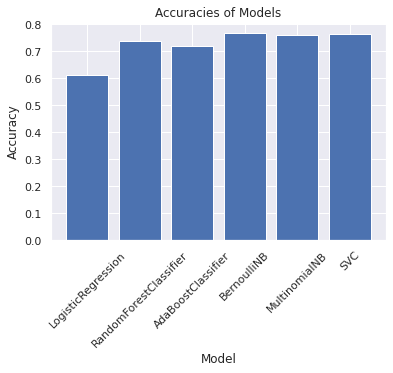

In [ ]:
Index = [1,2,3,4,5,6]
plt.bar(Index,Accuracy)
plt.xticks(Index, Model,rotation=45)
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.title('Accuracies of Models')